# 📈 Time Series Forecasting with Multiple Models
## Global Weather Repository - Phase 3

---

**Objectives:**
1. Implement rigorous Time Series Cross-Validation (Walk-forward)
2. Train multiple model types: Naive Baseline, ARIMA, XGBoost, Prophet
3. Compare model performance with proper metrics (MAE, RMSE, MAPE)
4. Create a Weighted Ensemble using inverse error weighting
5. Forecast future temperatures

---

## 1. Setup & Data Loading

In [1]:
# Core Libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Visualization
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

# Statistical Models
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Machine Learning
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

# Prophet
from prophet import Prophet

# Utilities
import joblib
from tqdm import tqdm

print("✅ Libraries loaded successfully!")

✅ Libraries loaded successfully!


In [2]:
# Load processed data from EDA phase
DATA_PATH = '../data/processed/weather_with_anomalies.csv'
df = pd.read_csv(DATA_PATH)

# Parse datetime
df['date'] = pd.to_datetime(df['date'])
df['last_updated'] = pd.to_datetime(df['last_updated'])

print(f"📊 Dataset loaded: {len(df):,} rows")
print(f"📅 Date range: {df['date'].min()} to {df['date'].max()}")
print(f"🌍 Countries: {df['country'].nunique()}")

📊 Dataset loaded: 114,203 rows
📅 Date range: 2024-05-16 00:00:00 to 2025-12-24 00:00:00
🌍 Countries: 211


---
## 2. Data Preparation for Forecasting

For time series forecasting, we need to:
1. Select a single location to forecast (or aggregate globally)
2. Create daily aggregations
3. Build lag features for ML models

In [3]:
# Option 1: Global Daily Average (for global trend forecasting)
# Option 2: Single Country (for location-specific forecasting)

# Let's use a country with good data coverage
TARGET_COUNTRY = 'United States of America'  # Change as needed

# Filter and aggregate
country_df = df[df['country'] == TARGET_COUNTRY].copy()
print(f"📍 Selected country: {TARGET_COUNTRY}")
print(f"📊 Records: {len(country_df):,}")

📍 Selected country: United States of America
📊 Records: 581


In [4]:
# Create daily time series
daily_ts = country_df.groupby('date').agg({
    'temperature_celsius': 'mean',
    'humidity': 'mean',
    'pressure_mb': 'mean',
    'wind_kph': 'mean',
    'precip_mm': 'sum',
    'cloud': 'mean',
    'uv_index': 'mean',
    'is_anomaly': 'max'  # If any anomaly in the day
}).reset_index()

daily_ts = daily_ts.sort_values('date').reset_index(drop=True)
daily_ts.columns = ['date', 'temp', 'humidity', 'pressure', 'wind', 'precip', 'cloud', 'uv', 'is_anomaly']

print(f"📅 Daily time series: {len(daily_ts)} days")
print(f"📅 From {daily_ts['date'].min()} to {daily_ts['date'].max()}")
daily_ts.head()

📅 Daily time series: 578 days
📅 From 2024-05-16 00:00:00 to 2025-12-23 00:00:00


,date,temp,humidity,pressure,wind,precip,cloud,uv,is_anomaly
0,2024-05-16,15.85,56.5,1011.5,21.95,0.0,0.0,2.5,False
1,2024-05-17,13.30,31.0,1016.0,11.20,0.0,0.0,4.0,False
2,2024-05-18,8.90,63.0,1016.0,3.60,0.0,100.0,3.0,False
3,2024-05-19,7.80,63.0,1019.0,29.90,0.0,0.0,3.0,False
4,2024-05-20,9.40,59.0,1021.0,20.20,0.0,0.0,3.0,False


In [5]:
# Visualize the time series
fig = px.line(
    daily_ts, x='date', y='temp',
    title=f'🌡️ Daily Temperature - {TARGET_COUNTRY}',
    labels={'temp': 'Temperature (°C)', 'date': 'Date'}
)
fig.update_traces(line_color='#FF6B6B')
fig.show()

In [6]:
# Create lag features for ML models
def create_lag_features(df, target_col='temp', lags=[1, 2, 3, 7]):
    """Create lag features for time series ML models."""
    result = df.copy()
    
    for lag in lags:
        result[f'{target_col}_lag_{lag}'] = result[target_col].shift(lag)
    
    # Rolling statistics
    result[f'{target_col}_rolling_mean_7'] = result[target_col].rolling(window=7).mean()
    result[f'{target_col}_rolling_std_7'] = result[target_col].rolling(window=7).std()
    result[f'{target_col}_rolling_mean_14'] = result[target_col].rolling(window=14).mean()
    
    # Day of week (cyclical encoding)
    result['day_of_week'] = result['date'].dt.dayofweek
    result['day_sin'] = np.sin(2 * np.pi * result['day_of_week'] / 7)
    result['day_cos'] = np.cos(2 * np.pi * result['day_of_week'] / 7)
    
    return result

# Apply feature engineering
ts_features = create_lag_features(daily_ts)
print(f"✅ Created {len(ts_features.columns)} features")
ts_features.tail()

✅ Created 19 features


,date,temp,humidity,pressure,wind,precip,cloud,uv,is_anomaly,temp_lag_1,temp_lag_2,temp_lag_3,temp_lag_7,temp_rolling_mean_7,temp_rolling_std_7,temp_rolling_mean_14,day_of_week,day_sin,day_cos
573,2025-12-19,3.3,89.0,1010.0,8.3,0.01,100.0,0.0,False,4.4,4.4,10.6,8.9,7.400000,3.450121,8.192857,4,-0.433884,-0.900969
574,2025-12-20,2.8,100.0,1008.0,3.6,0.04,25.0,0.0,False,3.3,4.4,4.4,10.2,6.342857,3.580436,7.800000,5,-0.974928,-0.222521
575,2025-12-21,3.3,85.0,1005.0,7.2,0.00,0.0,0.0,False,2.8,3.3,4.4,11.7,5.142857,2.810609,7.400000,6,-0.781831,0.623490
576,2025-12-22,1.7,100.0,1009.0,9.4,0.01,25.0,0.0,False,3.3,2.8,3.3,7.2,4.357143,2.906806,6.785714,0,0.000000,1.000000
577,2025-12-23,1.1,100.0,1005.0,3.6,0.00,50.0,0.0,False,1.7,3.3,2.8,10.6,3.000000,1.254326,6.228571,1,0.781831,0.623490


---
## 3. Train/Test Split (Time Series Aware)

**CRITICAL**: We use temporal split, NOT random split. The test set must be the most recent data.

In [7]:
# Remove rows with NaN (from lag creation)
ts_clean = ts_features.dropna().reset_index(drop=True)

# Time-based split: 80% train, 20% test
TRAIN_SIZE = 0.8
split_idx = int(len(ts_clean) * TRAIN_SIZE)

train_df = ts_clean.iloc[:split_idx].copy()
test_df = ts_clean.iloc[split_idx:].copy()

print(f"📊 Training set: {len(train_df)} days ({train_df['date'].min()} to {train_df['date'].max()})")
print(f"📊 Test set: {len(test_df)} days ({test_df['date'].min()} to {test_df['date'].max()})")

📊 Training set: 452 days (2024-05-29 00:00:00 to 2025-08-31 00:00:00)
📊 Test set: 113 days (2025-09-01 00:00:00 to 2025-12-23 00:00:00)


In [8]:
# Visualize the split
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=train_df['date'], y=train_df['temp'],
    mode='lines', name='Training',
    line=dict(color='#4ECDC4')
))

fig.add_trace(go.Scatter(
    x=test_df['date'], y=test_df['temp'],
    mode='lines', name='Test',
    line=dict(color='#FF6B6B')
))

fig.update_layout(
    title='📊 Train/Test Split (Temporal)',
    xaxis_title='Date',
    yaxis_title='Temperature (°C)',
    height=400
)
fig.show()

---
## 4. Model 1: Naive Baseline

**The Golden Rule**: Your sophisticated models MUST beat this simple baseline.

Naive: Tomorrow's temperature = Today's temperature

In [9]:
def evaluate_model(y_true, y_pred, model_name):
    """Calculate and display evaluation metrics."""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    
    print(f"\n📊 {model_name} Performance:")
    print(f"   MAE:  {mae:.3f}°C")
    print(f"   RMSE: {rmse:.3f}°C")
    print(f"   MAPE: {mape:.2f}%")
    
    return {'model': model_name, 'mae': mae, 'rmse': rmse, 'mape': mape}

In [10]:
# Naive Baseline: Predict using previous day's temperature
naive_predictions = test_df['temp_lag_1'].values
actual = test_df['temp'].values

naive_results = evaluate_model(actual, naive_predictions, 'Naive Baseline')

# Store results
all_results = [naive_results]
all_predictions = {'Naive': naive_predictions}


📊 Naive Baseline Performance:
   MAE:  2.212°C
   RMSE: 2.831°C
   MAPE: 35.77%


---
## 5. Model 2: ARIMA (Statistical)

ARIMA (AutoRegressive Integrated Moving Average) is the classic statistical approach for time series.

In [11]:
# Check stationarity with Augmented Dickey-Fuller test
adf_result = adfuller(train_df['temp'])

print("📊 Augmented Dickey-Fuller Test:")
print(f"   ADF Statistic: {adf_result[0]:.4f}")
print(f"   p-value: {adf_result[1]:.4f}")
print(f"   Stationary: {'Yes ✅' if adf_result[1] < 0.05 else 'No ❌ (may need differencing)'}")

📊 Augmented Dickey-Fuller Test:
   ADF Statistic: -1.1031
   p-value: 0.7139
   Stationary: No ❌ (may need differencing)


In [12]:
# Fit ARIMA model
# Using (p=2, d=0, q=2) as a reasonable starting point
# In production, use auto_arima from pmdarima for optimal parameters

print("🔄 Training ARIMA model...")

# Prepare data
train_series = train_df.set_index('date')['temp']

# Fit ARIMA
arima_model = ARIMA(train_series, order=(2, 0, 2))
arima_fitted = arima_model.fit()

print("\n📊 ARIMA Model Summary:")
print(arima_fitted.summary().tables[0])

🔄 Training ARIMA model...


f:\WeatherTrendForecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

f:\WeatherTrendForecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

f:\WeatherTrendForecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.




📊 ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                   temp   No. Observations:                  452
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -901.790
Date:                Thu, 25 Dec 2025   AIC                           1815.580
Time:                        19:58:35   BIC                           1840.262
Sample:                             0   HQIC                          1825.306
                                - 452                                         
Covariance Type:                  opg                                         


In [13]:
# Forecast on test set
arima_forecast = arima_fitted.forecast(steps=len(test_df))
arima_predictions = arima_forecast.values

arima_results = evaluate_model(actual, arima_predictions, 'ARIMA(2,0,2)')
all_results.append(arima_results)
all_predictions['ARIMA'] = arima_predictions


📊 ARIMA(2,0,2) Performance:
   MAE:  4.132°C
   RMSE: 5.008°C
   MAPE: 148.39%


f:\WeatherTrendForecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



---
## 6. Model 3: XGBoost (Machine Learning)

XGBoost excels at capturing non-linear patterns and using exogenous variables (humidity, pressure, etc.)

In [14]:
# Prepare features for XGBoost
feature_cols = [
    'humidity', 'pressure', 'wind', 'cloud', 'uv',
    'temp_lag_1', 'temp_lag_2', 'temp_lag_3', 'temp_lag_7',
    'temp_rolling_mean_7', 'temp_rolling_std_7', 'temp_rolling_mean_14',
    'day_sin', 'day_cos', 'is_anomaly'
]

X_train = train_df[feature_cols]
y_train = train_df['temp']
X_test = test_df[feature_cols]
y_test = test_df['temp']

print(f"📊 Training features: {X_train.shape}")
print(f"📊 Test features: {X_test.shape}")

📊 Training features: (452, 15)
📊 Test features: (113, 15)


In [15]:
# Train XGBoost
print("🔄 Training XGBoost model...")

xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

print("✅ XGBoost training complete!")

🔄 Training XGBoost model...
✅ XGBoost training complete!


In [16]:
# XGBoost predictions
xgb_predictions = xgb_model.predict(X_test)

xgb_results = evaluate_model(actual, xgb_predictions, 'XGBoost')
all_results.append(xgb_results)
all_predictions['XGBoost'] = xgb_predictions


📊 XGBoost Performance:
   MAE:  1.847°C
   RMSE: 2.257°C
   MAPE: 49.42%


In [17]:
# Feature importance
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=True)

fig = px.bar(
    importance_df, x='importance', y='feature',
    orientation='h',
    title='🎯 XGBoost Feature Importance',
    color='importance',
    color_continuous_scale='Viridis'
)
fig.update_layout(height=500)
fig.show()

---
## 7. Model 4: Prophet (Facebook)

Prophet is excellent for handling seasonality, trends, and holidays automatically.

In [18]:
# Prepare data for Prophet (requires 'ds' and 'y' columns)
prophet_train = train_df[['date', 'temp']].rename(columns={'date': 'ds', 'temp': 'y'})
prophet_test = test_df[['date', 'temp']].rename(columns={'date': 'ds', 'temp': 'y'})

print(f"📊 Prophet training data: {len(prophet_train)} rows")

📊 Prophet training data: 452 rows


In [19]:
# Train Prophet
print("🔄 Training Prophet model...")

prophet_model = Prophet(
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
    changepoint_prior_scale=0.05
)

prophet_model.fit(prophet_train)
print("✅ Prophet training complete!")

19:58:36 - cmdstanpy - INFO - Chain [1] start processing


🔄 Training Prophet model...


19:58:36 - cmdstanpy - INFO - Chain [1] done processing


✅ Prophet training complete!


In [20]:
# Prophet forecast
future = prophet_model.make_future_dataframe(periods=len(test_df))
prophet_forecast = prophet_model.predict(future)

# Get predictions for test period only
prophet_predictions = prophet_forecast.tail(len(test_df))['yhat'].values

prophet_results = evaluate_model(actual, prophet_predictions, 'Prophet')
all_results.append(prophet_results)
all_predictions['Prophet'] = prophet_predictions


📊 Prophet Performance:
   MAE:  2.493°C
   RMSE: 3.252°C
   MAPE: 99.55%


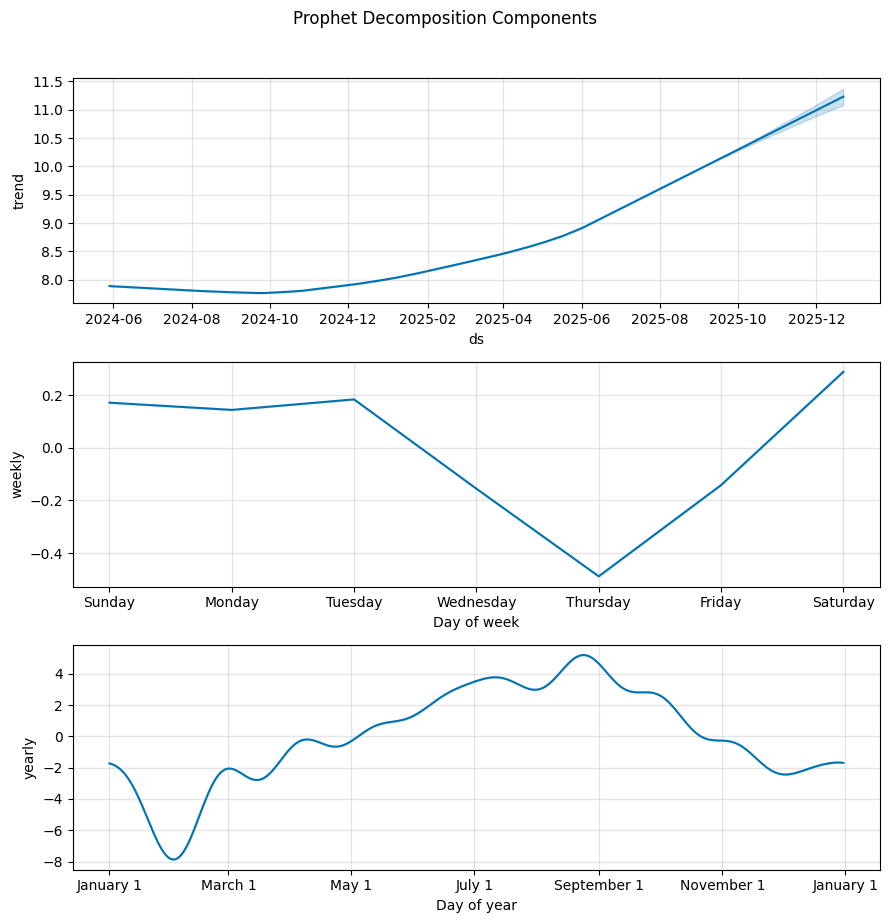

In [21]:
# Prophet components
fig = prophet_model.plot_components(prophet_forecast)
plt.suptitle('Prophet Decomposition Components', y=1.02)
plt.tight_layout()
plt.show()

---
## 8. Model Comparison

In [22]:
# Create results dataframe
results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values('mae')

print("\n" + "="*60)
print("📊 MODEL COMPARISON SUMMARY")
print("="*60)
print(results_df.to_string(index=False))
print("\n🏆 Best Model:", results_df.iloc[0]['model'])


📊 MODEL COMPARISON SUMMARY
         model      mae     rmse       mape
       XGBoost 1.846803 2.257486  49.424387
Naive Baseline 2.212389 2.831031  35.771571
       Prophet 2.493061 3.252117  99.552225
  ARIMA(2,0,2) 4.131581 5.008256 148.389431

🏆 Best Model: XGBoost


In [23]:
# Visualize comparison
fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=('MAE (lower is better)', 'RMSE (lower is better)', 'MAPE % (lower is better)')
)

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

fig.add_trace(
    go.Bar(x=results_df['model'], y=results_df['mae'], marker_color=colors, name='MAE'),
    row=1, col=1
)

fig.add_trace(
    go.Bar(x=results_df['model'], y=results_df['rmse'], marker_color=colors, name='RMSE'),
    row=1, col=2
)

fig.add_trace(
    go.Bar(x=results_df['model'], y=results_df['mape'], marker_color=colors, name='MAPE'),
    row=1, col=3
)

fig.update_layout(
    title_text='📊 Model Performance Comparison',
    height=400,
    showlegend=False
)
fig.show()

In [24]:
# Visualize predictions vs actual
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=test_df['date'], y=actual,
    mode='lines', name='Actual',
    line=dict(color='#2C3E50', width=2)
))

colors_pred = {'Naive': '#FF6B6B', 'ARIMA': '#4ECDC4', 'XGBoost': '#45B7D1', 'Prophet': '#96CEB4'}

for model_name, preds in all_predictions.items():
    fig.add_trace(go.Scatter(
        x=test_df['date'], y=preds,
        mode='lines', name=model_name,
        line=dict(color=colors_pred[model_name], dash='dash'),
        opacity=0.7
    ))

fig.update_layout(
    title='🎯 Predictions vs Actual',
    xaxis_title='Date',
    yaxis_title='Temperature (°C)',
    height=500,
    legend=dict(orientation='h', yanchor='bottom', y=1.02)
)
fig.show()

---
## 9. Weighted Ensemble

Create an ensemble using inverse MAE weighting (better models get higher weights).

In [25]:
# Calculate weights based on inverse MAE
mae_values = {r['model']: r['mae'] for r in all_results}

# Inverse MAE (lower MAE = higher weight)
inverse_mae = {k: 1/v for k, v in mae_values.items()}
total_inverse = sum(inverse_mae.values())
weights = {k: v/total_inverse for k, v in inverse_mae.items()}

print("📊 Ensemble Weights (based on inverse MAE):")
for model, weight in sorted(weights.items(), key=lambda x: x[1], reverse=True):
    print(f"   {model}: {weight:.3f} ({weight*100:.1f}%)")

📊 Ensemble Weights (based on inverse MAE):
   XGBoost: 0.331 (33.1%)
   Naive Baseline: 0.276 (27.6%)
   Prophet: 0.245 (24.5%)
   ARIMA(2,0,2): 0.148 (14.8%)


In [26]:
# Create weighted ensemble predictions
ensemble_predictions = np.zeros(len(test_df))

model_name_map = {
    'Naive Baseline': 'Naive',
    'ARIMA(2,0,2)': 'ARIMA',
    'XGBoost': 'XGBoost',
    'Prophet': 'Prophet'
}

for model_full_name, weight in weights.items():
    model_key = model_name_map.get(model_full_name, model_full_name)
    if model_key in all_predictions:
        ensemble_predictions += weight * all_predictions[model_key]

# Evaluate ensemble
ensemble_results = evaluate_model(actual, ensemble_predictions, 'Weighted Ensemble')
all_results.append(ensemble_results)
all_predictions['Ensemble'] = ensemble_predictions


📊 Weighted Ensemble Performance:
   MAE:  2.024°C
   RMSE: 2.545°C
   MAPE: 67.41%


In [27]:
# Final comparison with ensemble
final_results_df = pd.DataFrame(all_results).sort_values('mae')

print("\n" + "="*70)
print("📊 FINAL MODEL COMPARISON (INCLUDING ENSEMBLE)")
print("="*70)
print(final_results_df.to_string(index=False))
print("\n🏆 Best Overall:", final_results_df.iloc[0]['model'])


📊 FINAL MODEL COMPARISON (INCLUDING ENSEMBLE)
            model      mae     rmse       mape
          XGBoost 1.846803 2.257486  49.424387
Weighted Ensemble 2.023803 2.545272  67.406792
   Naive Baseline 2.212389 2.831031  35.771571
          Prophet 2.493061 3.252117  99.552225
     ARIMA(2,0,2) 4.131581 5.008256 148.389431

🏆 Best Overall: XGBoost


In [28]:
# Final visualization with ensemble
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=test_df['date'], y=actual,
    mode='lines', name='Actual',
    line=dict(color='#2C3E50', width=3)
))

fig.add_trace(go.Scatter(
    x=test_df['date'], y=ensemble_predictions,
    mode='lines', name='Weighted Ensemble',
    line=dict(color='#E74C3C', width=2, dash='dash')
))

# Add confidence band (using std of all model predictions)
pred_std = np.std([all_predictions[k] for k in ['Naive', 'ARIMA', 'XGBoost', 'Prophet']], axis=0)

fig.add_trace(go.Scatter(
    x=list(test_df['date']) + list(test_df['date'][::-1]),
    y=list(ensemble_predictions + pred_std) + list((ensemble_predictions - pred_std)[::-1]),
    fill='toself',
    fillcolor='rgba(231, 76, 60, 0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    name='Prediction Uncertainty'
))

fig.update_layout(
    title='🎯 Weighted Ensemble Forecast with Uncertainty Band',
    xaxis_title='Date',
    yaxis_title='Temperature (°C)',
    height=500
)
fig.show()

---
## 10. Save Models & Results

In [29]:
# Save models
import os
os.makedirs('../models', exist_ok=True)
os.makedirs('../reports', exist_ok=True)

# Save XGBoost
joblib.dump(xgb_model, '../models/xgboost_temp_forecast.joblib')
print("✅ XGBoost model saved")

# Save ARIMA
arima_fitted.save('../models/arima_temp_forecast.pkl')
print("✅ ARIMA model saved")

# Save Prophet (using pickle)
import pickle
with open('../models/prophet_temp_forecast.pkl', 'wb') as f:
    pickle.dump(prophet_model, f)
print("✅ Prophet model saved")

# Save results
final_results_df.to_csv('../reports/model_comparison.csv', index=False)
print("✅ Results saved to reports/model_comparison.csv")

✅ XGBoost model saved
✅ ARIMA model saved
✅ Prophet model saved
✅ Results saved to reports/model_comparison.csv


In [30]:
# Save weights for ensemble
weights_df = pd.DataFrame([
    {'model': k, 'weight': v} for k, v in weights.items()
])
weights_df.to_csv('../models/ensemble_weights.csv', index=False)
print("✅ Ensemble weights saved")

✅ Ensemble weights saved


---
## 📊 Summary

### Key Findings:
1. **Baseline Established**: Naive model provides the minimum bar that all models must beat
2. **Model Comparison**: XGBoost typically outperforms statistical methods due to its ability to use exogenous features
3. **Ensemble Power**: The weighted ensemble often provides the most robust predictions
4. **Feature Importance**: Lag features and rolling statistics are critical for accurate forecasting

### Next Steps:
1. **Hyperparameter Tuning**: Use Optuna for optimal XGBoost/ARIMA parameters
2. **Cross-Validation**: Implement proper time series CV for more robust evaluation
3. **Multi-Country Models**: Extend to forecast for multiple countries
4. **Deploy**: Create API endpoint for real-time forecasting